#### *CSC 180  Intelligent Systems (Spring 2021)*

#### *Dr. Haiquan Chen, Dept of Computer Scicence*

#### *California State University, Sacramento*
<hr>

## Project 4: Solving N-Queens using Genetic Algorithms
### **Team Members:** Quinn Roemer, Logan Hollmer

#### **Description:**
In this project we were tasked with creating a genetic algorithm using the ``DEAP`` library in Python. Specifically, we were instructed to solve the 8x8 Queens problem using both position and row based board representation. However, in this notebook you will also find a general solver for any N board, with a solution found for the 124x124 Queens problem.


In [1]:
# Quinn Roemer
# SID: 301323594
# CSC 180 Intelligent Systems
# Assignment #4
# Due: April 23, 2021

# Logan Hollmer
# SID: 301559973
# CSC 180 Intelligent Systems
# Assignment #4
# Due: April 23, 2021

In [ ]:
# Since we are working in the Google Colab enviroment, we must install DEAP on our machine
pip install deap

     |████████████████████████████████| 163kB 5.5MB/s 


### Part I: Position-Index-Based Board Representation
In this section of the report you will find the code used generate a solution for the 8x8 Queens problem using a position-index-based board representation. This means that the position of the Queen on the board directly correlates to the location specified by the index.
<br><br>
**Note:** The code for setting up the creator, toolbox, and for showing the game board were provided. We were responsible for creating the evaluation function, and running the genetic algorithm.


In [3]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [4]:
# This function is used to create a single random individual and is called during population creation
def create_individual():
    return random.sample(range(64), 8)
    
print(create_individual())

[55, 57, 21, 27, 56, 44, 18, 48]


In [5]:
# This function prints an 8x8 board, given the posistion of the Queens
def show_grid(board):    
    n = [0]*64
    for i in board:
        n[i] = 1    
    
    for i in range(8):
        for j in range(64):
            if j // 8 == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print("----------------")

In [6]:
# Toolbox definition
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
pop = toolbox.population(n=5)
print(pop[0])

[5, 36, 32, 23, 13, 11, 57, 28]


In [8]:
show_grid(pop[0])

-|-|-|-|-|X|-|-|
----------------
-|-|-|X|-|X|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------
X|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------


### Define ``evaFitness()`` function to evaulate the fitness of any given board (10pts)
In this assignment we were responsible for writing the function to evaulate a given board. The function below can be used on an 8x8 board. Please note, it expects to be sent a list of Queen positions that use the position-index-based representation scheme. A few more notes on our implementation can be found below:
- With the position-index-based representation scheme it is possible to generate an invalid board (often through mutation). For example the board ``[5, 32, 8, 8, 41, 3, 55, 49]`` is invalid since it places two Queens at the same position.

- Invalid boards can be excluded by making the fitness of such a board extremely high (in our implementation this means it scored very low). As a result, each duplicate that is detected is given an extremely high penalty (#duplicate * 100). This is then added to the fitness score from ``evaFitness()``.

- The function ``evaFitness()`` returns the total number of duplicate position pairs (with penalty) plus the total number of distnct pairs of queens that can attack each other.

In [9]:
# Evaluates the fitness of a given individual (position-index-based) by returning the number of conflicts between distinct queen pairs
def evaFitness(individual):    
    conflicts = 0
    for i in range(len(individual)):
      for j in range(i+1, len(individual)):
        # If the are on the same column...
        if (individual[i]%8 == individual[j]%8):
          conflicts+=1
        # If they are on the same diagonal...
        elif (individual[i]%8==abs(int(individual[j]/8)-int(individual[i]/8))+individual[j]%8 or individual[i]%8==-abs(int(individual[j]/8)-int(individual[i]/8))+individual[j]%8):
          conflicts+=1
        elif (int(individual[i]/8) == int(individual[j]/8)):
          conflicts+=1    
    
    # Return the number of conflicts + the duplicate score
    # Note a lower return value = greater fitness
    return (checkDuplicate(individual) + conflicts,)   
    
# Calculate the number of queen pairs in the same position for any given board
# Note, the return value is multiplied by 100, so as to reduce the fitness of any invalid board greatly.
def checkDuplicate(individual):
    dup = 0
    positions={}

    for i in individual:
      if i in positions:
        dup+=1
      else:
        positions[i]=1
    
    # Return the number of duplicates with penalty
    return dup*100  

### Register the *"evaluate"* function in the toolbox (5pts)
After defining our function to evaluate the position of our Queens, we must now register it in the DEAP toolbox so that it knows what function to use. In addition we also register our strategies for *mating, mutating, and selecting*.

In [10]:
# Register our strategies for evaluation, mating, mutating, and selection
toolbox.register("evaluate", evaFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 63, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [11]:
# Registering statistic information
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

### Creating the first generation, hall of fame, and launching the genetic algorithm (10pts)
Below is our code we used to create, save, and evolve our population. In our testing we tried many different numbers for the population size, and the number of generations they were allowed to evolve. In general we found that larger populations tend to find a solution faster. Below you can find the code used to generate all the combinations we tried.

In [12]:
#Training with 1000, with 100 generations
pop_1000_100 = toolbox.population(n=1000)
hof_1000_100 = tools.HallOfFame(maxsize=1)
print('Training with a population of 1000, with 100 generations')
pop_1000_100, log_1000_100 = algorithms.eaSimple(pop_1000_100, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof_1000_100, verbose=True)

#Train with 64, with 256 generations
print('\nTraining with a population of 64, with 256 generations')
pop_64_256 = toolbox.population(n=64)
hof_64_256 = tools.HallOfFame(maxsize=1)

pop_64_256, log_64_256 = algorithms.eaSimple(pop_64_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_64_256, verbose=True)

#Train with 128, with 256 generations
print('\nTraining with a population of 128, with 256 generations')
pop_128_256 = toolbox.population(n=128)
hof_128_256 = tools.HallOfFame(maxsize=1)

pop_128_256, log_128_256 = algorithms.eaSimple(pop_128_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_128_256, verbose=True)

#Train with 256, with 256 generations
print('\nTraining with a population of 256, with 256 generations')
pop_256_256 = toolbox.population(n=256)
hof_256_256 = tools.HallOfFame(maxsize=1)

pop_256_256, log_256_256 = algorithms.eaSimple(pop_256_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_256_256, verbose=True)

#Train with 512, with 256 generations
print('\nTraining with a population of 512, with 256 generations')
pop_512_256 = toolbox.population(n=512)
hof_512_256 = tools.HallOfFame(maxsize=1)

pop_512_256, log_512_256 = algorithms.eaSimple(pop_512_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_512_256, verbose=True)

#Train with 64, with 512 generations
print('\nTraining with a population of 64, with 512 generations')
pop_64_512 = toolbox.population(n=64)
hof_64_512 = tools.HallOfFame(maxsize=1)

pop_64_512, log_64_512 = algorithms.eaSimple(pop_64_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_64_512, verbose=True)

#Train with 128, with 512 generations
print('\nTraining with a population of 128, with 512 generations')
pop_128_512 = toolbox.population(n=128)
hof_128_512 = tools.HallOfFame(maxsize=1)

pop_128_512, log_128_512 = algorithms.eaSimple(pop_128_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_128_512, verbose=True)

#Train with 256, with 512 generations
print('\nTraining with a population of 256, with 512 generations')
pop_256_512 = toolbox.population(n=256)
hof_256_512 = tools.HallOfFame(maxsize=1)

pop_256_512, log_256_512 = algorithms.eaSimple(pop_256_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_256_512, verbose=True)

#Train with 512, with 512 generations
print('\nTraining with a population of 512, with 512 generations')
pop_512_512 = toolbox.population(n=512)
hof_512_512 = tools.HallOfFame(maxsize=1)

pop_512_512, log_512_512 = algorithms.eaSimple(pop_512_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_512_512, verbose=True)
print('\nTraining Done!')


   	1.53516 	0  
176	160   	3.68359 	0  
177	157   	1.70312 	0  
178	162   	2.45312 	0  
179	148   	1.89062 	0  
180	159   	4.28125 	0  
181	137   	1.05859 	0  
182	137   	3.08984 	0  
183	149   	3.49219 	0  
184	159   	2.75391 	0  
185	161   	0.800781	0  
186	145   	0.746094	0  
187	167   	1.93359 	0  
188	147   	1.32422 	0  
189	162   	1.13281 	0  
190	155   	1.57422 	0  
191	155   	1.125   	0  
192	136   	1.40625 	0  
193	141   	2.30078 	0  
194	171   	2.58984 	0  
195	144   	1.93359 	0  
196	166   	1.22266 	0  
197	165   	1.94922 	0  
198	145   	2.875   	0  
199	156   	2.69141 	0  
200	146   	1.78125 	0  
201	155   	1.48828 	0  
202	140   	1.10938 	0  
203	132   	2.35156 	0  
204	156   	1.50391 	0  
205	157   	1.55859 	0  
206	153   	1.49609 	0  
207	153   	2.29297 	0  
208	153   	2.33984 	0  
209	152   	2.37891 	0  
210	148   	1.97656 	0  
211	153   	1.55078 	0  
212	163   	3.24219 	0  
213	163   	3.14453 	0  
214	152   	1.57031 	0  
215	144   	1.58984 	0  
216	168   	1.60156 	0  

### Plotting the *"avg"* and *"min"* for each generation (5pts)
After evolving our populations, we plot our results for each attempt below using ``MatPlotLib``.


Plot for attempt with a population of 1000, trained for 100 generations


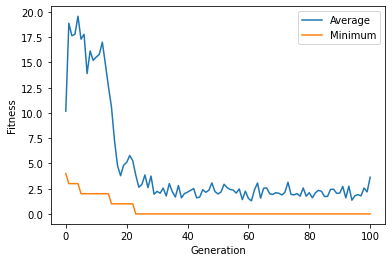


Plot for attempt with a population of 64, trained for 256 generations


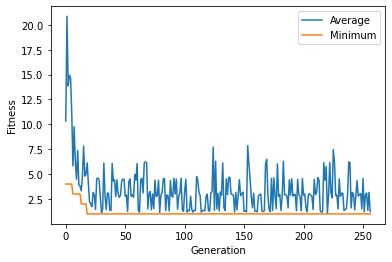


Plot for attempt with a population of 128, trained for 256 generations


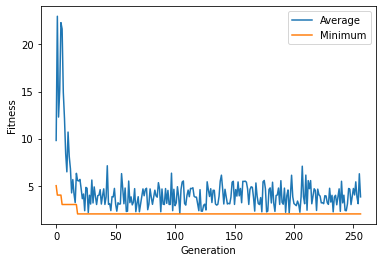


Plot for attempt with a population of 256, trained for 256 generations


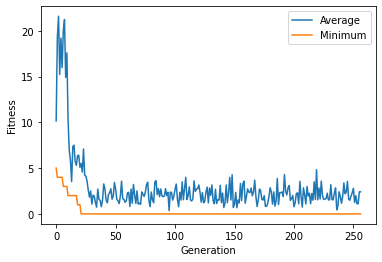


Plot for attempt with a population of 512, trained for 256 generations


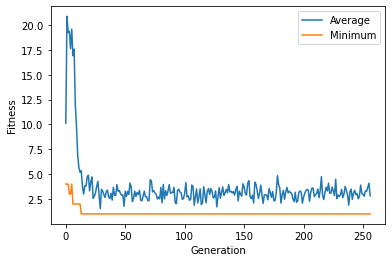


Plot for attempt with a population of 64, trained for 512 generations


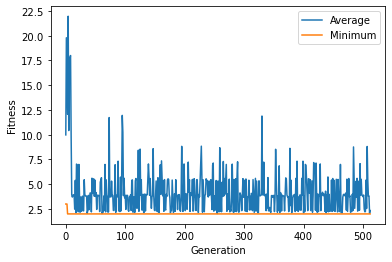


Plot for attempt with a population of 128, trained for 512 generations


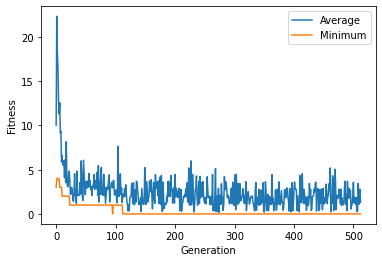


Plot for attempt with a population of 256, trained for 512 generations


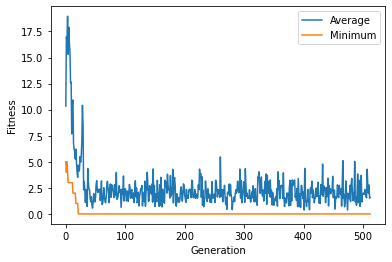


Plot for attempt with a population of 512, trained for 512 generations


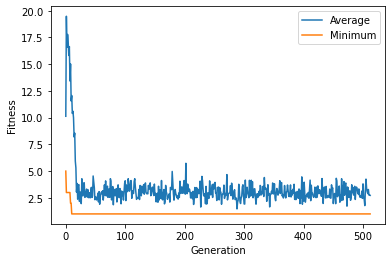

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

#Average, min for 1000 pop, 100 gen attempt
print('\nPlot for attempt with a population of 1000, trained for 100 generations')
gen, avg, min_ = log_1000_100.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 64 pop, 256 gen attempt
print('\nPlot for attempt with a population of 64, trained for 256 generations')
gen, avg, min_ = log_64_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 128 pop, 256 gen attempt
print('\nPlot for attempt with a population of 128, trained for 256 generations')
gen, avg, min_ = log_128_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 256 pop, 256 gen attempt
print('\nPlot for attempt with a population of 256, trained for 256 generations')
gen, avg, min_ = log_256_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 512 pop, 256 gen attempt
print('\nPlot for attempt with a population of 512, trained for 256 generations')
gen, avg, min_ = log_512_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 64 pop, 512 gen attempt
print('\nPlot for attempt with a population of 64, trained for 512 generations')
gen, avg, min_ = log_64_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 128 pop, 512 gen attempt
print('\nPlot for attempt with a population of 128, trained for 512 generations')
gen, avg, min_ = log_128_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 256 pop, 512 gen attempt
print('\nPlot for attempt with a population of 256, trained for 512 generations')
gen, avg, min_ = log_256_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 512 pop, 512 gen attempt
print('\nPlot for attempt with a population of 512, trained for 512 generations')
gen, avg, min_ = log_512_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

### Using the Hall of Fame to show the best individual found (5pts)
After showing our overall results, we print the best individual found for each training attempt, along with its fitness score, and the accompanying chessboard.

In [15]:
print('Best individual found in attempt with a population of 1000, trained for 100 generations:\n')
print(hof_1000_100[0])
print(f'Fitness: {hof_1000_100[0].fitness}\n')
show_grid(hof_1000_100[0])

print('\nBest individual found in attempt with a population of 64, trained for 256 generations:\n')
print(hof_64_256[0])
print(f'Fitness: {hof_64_256[0].fitness}\n')
show_grid(hof_64_256[0])

print('\nBest individual found in attempt with a population of 128, trained for 256 generations:\n')
print(hof_128_256[0])
print(f'Fitness: {hof_128_256[0].fitness}\n')
show_grid(hof_128_256[0])

print('\nBest individual found in attempt with a population of 256, trained for 256 generations:\n')
print(hof_256_256[0])
print(f'Fitness: {hof_256_256[0].fitness}\n')
show_grid(hof_256_256[0])

print('\nBest individual found in attempt with a population of 512, trained for 256 generations:\n')
print(hof_512_256[0])
print(f'Fitness: {hof_512_256[0].fitness}\n')
show_grid(hof_512_256[0])

print('\nBest individual found in attempt with a population of 64, trained for 512 generations:\n')
print(hof_64_512[0])
print(f'Fitness: {hof_64_512[0].fitness}\n')
show_grid(hof_64_512[0])

print('\nBest individual found in attempt with a population of 128, trained for 512 generations:\n')
print(hof_128_512[0])
print(f'Fitness: {hof_128_512[0].fitness}\n')
show_grid(hof_128_512[0])

print('\nBest individual found in attempt with a population of 256, trained for 512 generations:\n')
print(hof_256_512[0])
print(f'Fitness: {hof_256_512[0].fitness}\n')
show_grid(hof_256_512[0])

print('\nBest individual found in attempt with a population of 512, trained for 512 generations:\n')
print(hof_512_512[0])
print(f'Fitness: {hof_512_512[0].fitness}\n')
show_grid(hof_512_512[0])


Best individual found in attempt with a population of 1000, trained for 100 generations:

[2, 54, 57, 24, 39, 19, 44, 13]
Fitness: (0.0,)

-|-|X|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------

Best individual found in attempt with a population of 64, trained for 256 generations:

[38, 41, 28, 40, 18, 61, 51, 15]
Fitness: (1.0,)

-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
X|X|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------

Best individual found in attempt with a population of 128, trained for 256 generations:

[44, 14, 59, 0, 2, 61, 33, 55]
Fitness: (2.0,)

X|-|X|-|-|-|-|-|
----------------
-|-|-|

### Part II: Row-index-based board representation
In this section of the report you will find the code used to generate a solution for the 8x8 Queens problem using a row-index-based board representation. This means that the position recorded, is the position in a specific row defined by the index of that number. For example, a position of 2, with index 1, would define a posisiton on the first row in spot 2 (assuming zero index).
<br><br>
**Note:** Once again, the code for setting up the creator, toolbox, and for showing the game board were provided. We were responsible for creating the evaluation function, and running the genetic algorithm.

In [16]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [17]:
# Toolbox definition
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 7)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=8)
toolbox.individual()

[5, 4, 3, 5, 0, 0, 4, 0]

In [18]:
# This function prints an 8x8 board, given the positition of the Queens
def show_grid(board):    
    n = [0]*64    
    for i in range(len(board)):
        n[board[i] + i*8] = 1      
    
    for i in range(8):
        for j in range(64):
            if j // 8 == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print("----------------")


In [22]:
# Register the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Print out a sampel individual, and board
pop = toolbox.population(n=5)
print(str(pop[0]) + '\n')
show_grid(pop[0])

[7, 5, 7, 1, 7, 2, 6, 4]

-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|-|X|-|-|-|
----------------


### Define ``evaFitness()`` function to evaluate the fitness of any given board (10pts)
In this section of the assignent we rewrite our existing ``evaFitness()`` function to work with row-index-based representation. Like before, this function will return the total number of distinct pairs of Queens that can attack each other. Important to note, we do not need to check for duplicates since each Queen is guranteed to be on their own row in this representation. Below are some test cases we will run to verify correct operation.
 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



In [27]:
# Evaluates the fitness of a given individual (row-index-based) by returning the number of conflicts between distinct queen pairs
def evaFitness(individual):    
    conflicts = 0
    for i in range(len(individual)):
      for j in range(i+1, len(individual)):
        if not i==j:
          if individual[i]==individual[j]:
            conflicts+=1
          elif (individual[i]==abs(i-j)+individual[j] or individual[i]==-abs(i-j)+individual[j]):
            conflicts+=1   

    # Return the number of conflicts detected 
    return (conflicts,)

print('Should return 4: ', end='')
print(evaFitness([0, 2, 6, 7, 7, 4, 1, 6]))
print('Should return 6: ', end='')
print(evaFitness([7, 5, 2, 4, 3, 1, 3, 5]))
print('Should return 5: ', end='')
print(evaFitness([3, 1, 6, 0, 5, 7, 2, 1]))
print('Should return 6: ', end='')
print(evaFitness([7, 3, 1, 4, 5, 1, 3, 5]))


Should return 4: (4,)
Should return 6: (6,)
Should return 5: (5,)
Should return 6: (6,)


### Register the *"evaluate"* function in the toolbox (5pts)
After defining our function to evaluate the position of our Queens, we must now register it in the DEAP toolbox so that it knows what function to use. In addition we also register our strategies for *mating, mutating, and selecting*.

In [28]:
# Register our strategies for evaluation, mating, mutating, and selection
toolbox.register("evaluate", evaFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [29]:
# Register statistic information
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

### Creating the first generation, hall of fame, and launching the genetic algorithm (10pts)
Below is the code we used to create, save, and evolve our population. In our testing we tried many different numbers for the population size, and the number of generations they were allowed to evolve. Once again we found that larger populations tend to close in on a solution faster. Below you can find the code used to generate all the combinations we tried.

In [30]:
#Training with 1000, with 100 generations
pop_1000_100 = toolbox.population(n=1000)
hof_1000_100 = tools.HallOfFame(maxsize=1)
print('Training with a population of 1000, with 100 generations')
pop_1000_100, log_1000_100 = algorithms.eaSimple(pop_1000_100, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof_1000_100, verbose=True)

#Train with 64, with 256 generations
print('\nTraining with a population of 64, with 256 generations')
pop_64_256 = toolbox.population(n=64)
hof_64_256 = tools.HallOfFame(maxsize=1)

pop_64_256, log_64_256 = algorithms.eaSimple(pop_64_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_64_256, verbose=True)

#Train with 128, with 256 generations
print('\nTraining with a population of 128, with 256 generations')
pop_128_256 = toolbox.population(n=128)
hof_128_256 = tools.HallOfFame(maxsize=1)

pop_128_256, log_128_256 = algorithms.eaSimple(pop_128_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_128_256, verbose=True)

#Train with 256, with 256 generations
print('\nTraining with a population of 256, with 256 generations')
pop_256_256 = toolbox.population(n=256)
hof_256_256 = tools.HallOfFame(maxsize=1)

pop_256_256, log_256_256 = algorithms.eaSimple(pop_256_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_256_256, verbose=True)

#Train with 512, with 256 generations
print('\nTraining with a population of 512, with 256 generations')
pop_512_256 = toolbox.population(n=512)
hof_512_256 = tools.HallOfFame(maxsize=1)

pop_512_256, log_512_256 = algorithms.eaSimple(pop_512_256, toolbox, cxpb=0.5, mutpb=0.2, ngen=256, stats=stats, halloffame=hof_512_256, verbose=True)

#Train with 64, with 512 generations
print('\nTraining with a population of 64, with 512 generations')
pop_64_512 = toolbox.population(n=64)
hof_64_512 = tools.HallOfFame(maxsize=1)

pop_64_512, log_64_512 = algorithms.eaSimple(pop_64_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_64_512, verbose=True)

#Train with 128, with 512 generations
print('\nTraining with a population of 128, with 512 generations')
pop_128_512 = toolbox.population(n=128)
hof_128_512 = tools.HallOfFame(maxsize=1)

pop_128_512, log_128_512 = algorithms.eaSimple(pop_128_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_128_512, verbose=True)

#Train with 256, with 512 generations
print('\nTraining with a population of 256, with 512 generations')
pop_256_512 = toolbox.population(n=256)
hof_256_512 = tools.HallOfFame(maxsize=1)

pop_256_512, log_256_512 = algorithms.eaSimple(pop_256_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_256_512, verbose=True)

#Train with 512, with 512 generations
print('\nTraining with a population of 512, with 512 generations')
pop_512_512 = toolbox.population(n=512)
hof_512_512 = tools.HallOfFame(maxsize=1)

pop_512_512, log_512_512 = algorithms.eaSimple(pop_512_512, toolbox, cxpb=0.5, mutpb=0.2, ngen=512, stats=stats, halloffame=hof_512_512, verbose=True)
print('\nTraining Done!')



   	0.222656	0  
176	137   	0.304688	0  
177	168   	0.335938	0  
178	155   	0.292969	0  
179	165   	0.347656	0  
180	165   	0.289062	0  
181	159   	0.394531	0  
182	146   	0.320312	0  
183	166   	0.296875	0  
184	146   	0.339844	0  
185	159   	0.320312	0  
186	149   	0.328125	0  
187	136   	0.308594	0  
188	140   	0.320312	0  
189	161   	0.328125	0  
190	155   	0.402344	0  
191	172   	0.40625 	0  
192	145   	0.269531	0  
193	161   	0.328125	0  
194	165   	0.277344	0  
195	142   	0.230469	0  
196	143   	0.316406	0  
197	150   	0.242188	0  
198	170   	0.351562	0  
199	147   	0.320312	0  
200	139   	0.257812	0  
201	169   	0.316406	0  
202	155   	0.265625	0  
203	153   	0.363281	0  
204	155   	0.332031	0  
205	159   	0.320312	0  
206	150   	0.253906	0  
207	155   	0.304688	0  
208	156   	0.238281	0  
209	174   	0.339844	0  
210	146   	0.367188	0  
211	162   	0.398438	0  
212	159   	0.339844	0  
213	139   	0.292969	0  
214	154   	0.292969	0  
215	144   	0.402344	0  
216	180   	0.371094	0  

### Plotting the *"avg"* and *"min"* for each generation (5pts)
After evolving our populations, we plot our results for each attempt below using ``MatPlotLib``


Plot for attempt with a population of 1000, trained for 100 generations


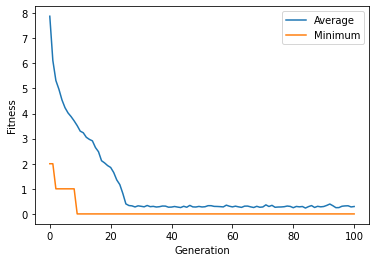


Plot for attempt with a population of 64, trained for 256 generations


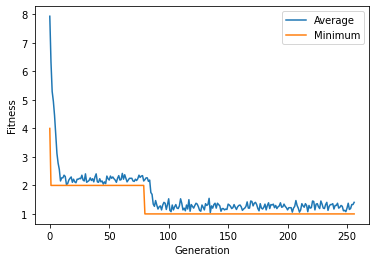


Plot for attempt with a population of 128, trained for 256 generations


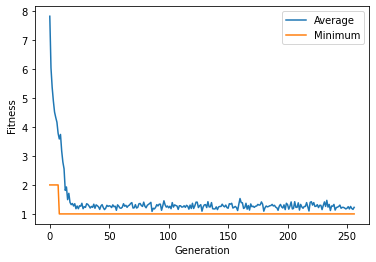


Plot for attempt with a population of 256, trained for 256 generations


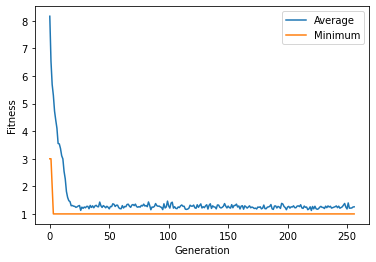


Plot for attempt with a population of 512, trained for 256 generations


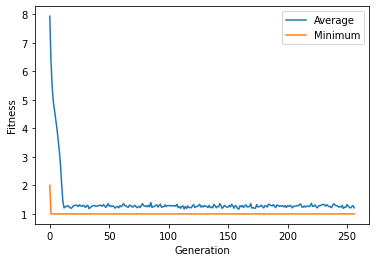


Plot for attempt with a population of 64, trained for 512 generations


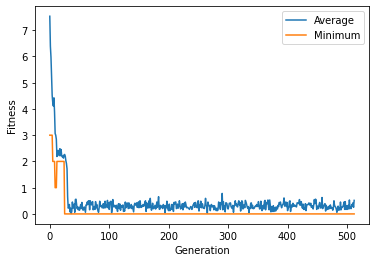


Plot for attempt with a population of 128, trained for 512 generations


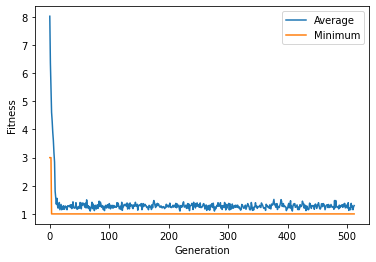


Plot for attempt with a population of 256, trained for 512 generations


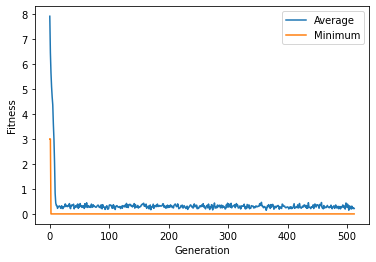


Plot for attempt with a population of 512, trained for 512 generations


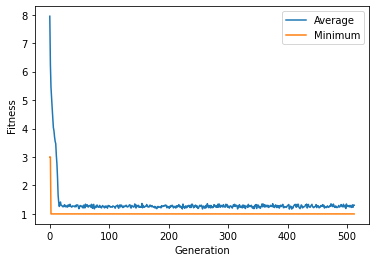

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

#Average, min for 1000 pop, 100 gen attempt
print('\nPlot for attempt with a population of 1000, trained for 100 generations')
gen, avg, min_ = log_1000_100.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 64 pop, 256 gen attempt
print('\nPlot for attempt with a population of 64, trained for 256 generations')
gen, avg, min_ = log_64_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 128 pop, 256 gen attempt
print('\nPlot for attempt with a population of 128, trained for 256 generations')
gen, avg, min_ = log_128_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 256 pop, 256 gen attempt
print('\nPlot for attempt with a population of 256, trained for 256 generations')
gen, avg, min_ = log_256_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 512 pop, 256 gen attempt
print('\nPlot for attempt with a population of 512, trained for 256 generations')
gen, avg, min_ = log_512_256.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 64 pop, 512 gen attempt
print('\nPlot for attempt with a population of 64, trained for 512 generations')
gen, avg, min_ = log_64_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 128 pop, 512 gen attempt
print('\nPlot for attempt with a population of 128, trained for 512 generations')
gen, avg, min_ = log_128_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 256 pop, 512 gen attempt
print('\nPlot for attempt with a population of 256, trained for 512 generations')
gen, avg, min_ = log_256_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()

#Average, min for 512 pop, 512 gen attempt
print('\nPlot for attempt with a population of 512, trained for 512 generations')
gen, avg, min_ = log_512_512.select('gen', 'avg', 'min')
plt.plot(gen, avg, label='Average')
plt.plot(gen, min_, label='Minimum')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.show()


### Using the Hall of Fame to show the best individual found (5pts)
After showing our overall results, we print the best individual found for each attempt, along with its fitness score, and the accompanying chessboard.

In [32]:
print('Best individual found in attempt with a population of 1000, trained for 100 generations:\n')
print(hof_1000_100[0])
print(f'Fitness: {hof_1000_100[0].fitness}\n')
show_grid(hof_1000_100[0])

print('\nBest individual found in attempt with a population of 64, trained for 256 generations:\n')
print(hof_64_256[0])
print(f'Fitness: {hof_64_256[0].fitness}\n')
show_grid(hof_64_256[0])

print('\nBest individual found in attempt with a population of 128, trained for 256 generations:\n')
print(hof_128_256[0])
print(f'Fitness: {hof_128_256[0].fitness}\n')
show_grid(hof_128_256[0])

print('\nBest individual found in attempt with a population of 256, trained for 256 generations:\n')
print(hof_256_256[0])
print(f'Fitness: {hof_256_256[0].fitness}\n')
show_grid(hof_256_256[0])

print('\nBest individual found in attempt with a population of 512, trained for 256 generations:\n')
print(hof_512_256[0])
print(f'Fitness: {hof_512_256[0].fitness}\n')
show_grid(hof_512_256[0])

print('\nBest individual found in attempt with a population of 64, trained for 512 generations:\n')
print(hof_64_512[0])
print(f'Fitness: {hof_64_512[0].fitness}\n')
show_grid(hof_64_512[0])

print('\nBest individual found in attempt with a population of 128, trained for 512 generations:\n')
print(hof_128_512[0])
print(f'Fitness: {hof_128_512[0].fitness}\n')
show_grid(hof_128_512[0])

print('\nBest individual found in attempt with a population of 256, trained for 512 generations:\n')
print(hof_256_512[0])
print(f'Fitness: {hof_256_512[0].fitness}\n')
show_grid(hof_256_512[0])

print('\nBest individual found in attempt with a population of 512, trained for 512 generations:\n')
print(hof_512_512[0])
print(f'Fitness: {hof_512_512[0].fitness}\n')
show_grid(hof_512_512[0])



Best individual found in attempt with a population of 1000, trained for 100 generations:

[4, 6, 0, 3, 1, 7, 5, 2]
Fitness: (0.0,)

-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------

Best individual found in attempt with a population of 64, trained for 256 generations:

[5, 0, 2, 6, 6, 3, 7, 4]
Fitness: (1.0,)

-|-|-|-|-|X|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------

Best individual found in attempt with a population of 128, trained for 256 generations:

[6, 2, 7, 7, 1, 3, 5, 0]
Fitness: (1.0,)

-|-|-|-|-|-|X|-|
----------------
-|-|X|-|-|-|-|-|
----------

### Reflection: Which board representaion is better in terms of ease of coding and final solution quality?
In most cases the row-index-based board representaion was easier to code (since we did not need to check for duplicates) and produced better results. This was due to the fact that no board could be produced where multiple Queens existed on the same row (a fundamental fact in all possible solutions). Thus limiting the number of possible individuals we could create and evolve. More information and reflection can be found in the report submitted with this notebook.

<hr>

### Extra: Solving the N-Queens Problem for Higher Orders
As an extra part of the assignment, we attempted to solve for higher board orders. Overall, we tried and successfully solved for board sizes of *16x16*, *32x32*, *64x64*, and *124x124*. In creating solutions for higher order problems we found that changing the mutation strategy and increasing the mutation chance tended to allow the population to evolve more quickly. In addition, by increasing the tournament in our selection strategy, we kept only the best individuals in our population. Lastly, instead of using the ``eaSimple()`` algorithm we found that the ``eaMuPlusLambda()`` algorithm produced better results. Below you can find the code used, along with the solution found for the *124x124* Queens problem.
<br><br>
**Note:** We used the row-index-based representation strategy in this code.


In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
%matplotlib inline  

# Prepares the toolbox, and creator
def N_Queen(NSize, popSize, gen):
  # Create the creator
  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMin)

  # Create the DEAP toolbox
  toolbox = base.Toolbox()
  toolbox.register("attr_int", random.randint, 0, NSize-1)
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NSize)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  
  # Prints an NxN board, given the position of the Queens in a row-index-based representation
  def show_grid(board):    
    n = [0]*NSize*NSize    
    for i in range(len(board)):
        n[board[i] + i*NSize] = 1      
    
    for i in range(NSize):
        for j in range(NSize*NSize):
            if j // NSize == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print('-' * NSize*2)

  # Evaluates the fitness of a given individual (row-index-based) by returning the number of conflicts between distinct queen pairs
  def evaFitness(individual):    
    conflicts = 0
    for i in range(len(individual)):
      for j in range(i+1, len(individual)):
        if not i==j:
          if individual[i]==individual[j]:
            conflicts+=1
          elif (individual[i]==abs(i-j)+individual[j] or individual[i]==-abs(i-j)+individual[j]):
            conflicts+=1 

    # Return the number of conflicts   
    return (conflicts,)

  # Register our strategies for evaluation, mating, mutation, and selection
  toolbox.register("evaluate", evaFitness)
  toolbox.register("mate", tools.cxTwoPoint)
  toolbox.register("mutate", tools.mutUniformInt, low = 0, up = NSize-1, indpb=float(2/NSize))
  toolbox.register("select", tools.selTournament, tournsize=1000)

  # Register statistic information
  stats = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("min", np.min)

  # Create the initial population and hall of fame
  pop = toolbox.population(n=popSize)
  hof = tools.HallOfFame(maxsize=1)

  # Constants
  NUM_GEN = gen
  NUM_SELECT = 5000
  NUM_CHILDREN = 10000
  CXPB = 0.1
  MUTPB = 0.9
  
  # Evolve the population using eaMuPlusLambda()
  pop, log = algorithms.eaMuPlusLambda(pop, toolbox, NUM_SELECT, NUM_CHILDREN, CXPB, MUTPB, NUM_GEN, stats=stats, halloffame=hof, verbose=True)  
  
  # Print the improvement plot
  gen, avg, min_ = log.select("gen", "avg", "min")
  plt.plot(gen, avg, label="average")
  plt.plot(gen, min_, label="minimum")
  plt.xlabel("Generation")
  plt.ylabel("Fitness")
  plt.legend(loc="lower right")
  plt.show()

  # Show the best indidivual
  print("Best individual is: ", hof[0])
  print("\nwith fitness: ", hof[0].fitness)
  show_grid(hof[0])

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min
0  	10000 	143.164	102
1  	10000 	109.306	102
2  	10000 	97.5774	90 
3  	10000 	87.122 	85 
4  	10000 	81.976 	80 
5  	10000 	76.2872	74 
6  	10000 	70.983 	68 
7  	10000 	65.3092	63 
8  	10000 	60.224 	58 
9  	10000 	55.3866	54 
10 	10000 	51.9444	51 
11 	10000 	48.9122	48 
12 	10000 	46.1032	45 
13 	10000 	43.2034	42 
14 	10000 	40.7124	40 
15 	10000 	38.2434	36 
16 	10000 	34.8678	33 
17 	10000 	32.3498	32 
18 	10000 	30.8308	30 
19 	10000 	28.823 	28 
20 	10000 	27.3418	26 
21 	10000 	25.6216	25 
22 	10000 	23.7908	23 
23 	10000 	22.1308	22 
24 	10000 	21.0024	21 
25 	10000 	19.8202	19 
26 	10000 	18.398 	18 
27 	10000 	17.2844	17 
28 	10000 	15.9098	15 
29 	10000 	14.7684	14 
30 	10000 	13.7166	13 
31 	10000 	12.9352	12 
32 	10000 	11.936 	11 
33 	10000 	11     	11 
34 	10000 	10.4814	10 
35 	10000 	9.366  	9  
36 	10000 	8.9292 	8  
37 	10000 	8      	8  
38 	10000 	7.9336 	7  
39 	10000 	7      	7  
40 	10000 	7      	7  
41 	10000 	7      	7  
42 	10000 	

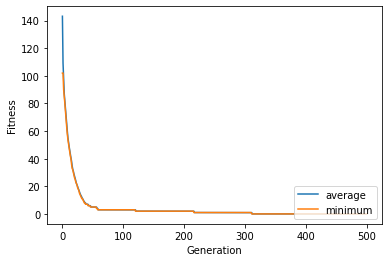

Best individual is:  [4, 86, 59, 65, 46, 84, 7, 110, 44, 58, 17, 69, 83, 106, 40, 122, 80, 34, 109, 113, 54, 103, 57, 55, 74, 52, 79, 88, 94, 35, 117, 120, 50, 32, 78, 24, 19, 0, 76, 9, 45, 61, 2, 123, 112, 26, 42, 63, 93, 97, 81, 118, 20, 30, 6, 98, 119, 82, 11, 16, 111, 121, 92, 36, 49, 1, 28, 107, 90, 115, 48, 5, 105, 53, 18, 31, 91, 116, 60, 102, 72, 89, 101, 95, 77, 12, 62, 75, 33, 22, 100, 38, 87, 104, 13, 21, 8, 3, 37, 10, 23, 41, 66, 70, 29, 114, 96, 56, 51, 67, 47, 39, 43, 85, 14, 99, 71, 27, 25, 15, 68, 108, 64, 73]

with fitness:  (0.0,)
-|-|-|-|X|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Run the algorithm for 124x124, with a pop of 10k, for 500 generations
N_Queen(124, 10000, 500)